# Creating a Custom Dataset for your files
A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

In the next sections, we’ll break down what’s happening in each of these functions.

In [1]:
import os
import torch
import pandas as pd
import torchvision
from torchvision.io import read_image

# __init__
The __init__ function is run once when instantiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).

The labels.csv file looks like:

tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9

In [2]:
class CustomImageDataset:
  def __init__(self, annotation_file , image_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotation_file)
    self.img_dir = image_dir
    self.transforms = transform
    self.target_transform = target_transform

  def len(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc(idx, 0))
    image = read_image(img_path)
    label =  self.img_labels.iloc(idx,1)
    if self.transforms:
      image = self.transforms(image)
    if self.target_transforms:
      label = self.target_transform(label)
    return image, label

# Preparing your data for training with DataLoaders
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

NameError: name 'training_data' is not defined

# Build the Neural Network
Neural networks comprise of layers/modules that perform operations on data. The torch.nn namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

In the following sections, we’ll build a neural network to classify images in the FashionMNIST dataset.

In [3]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Get Device for Training
We want to be able to train our model on a hardware accelerator like the GPU or MPS, if available. Let’s check to see if torch.cuda or torch.backends.mps are available, otherwise we use the CPU.

In [5]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

'cpu'

# Define the Class
We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

In [23]:
class NeuralNetwork(nn.Module):   #Inherit from nn.Module: The NeuralNetwork class now inherits from torch.nn.Module. This gives it access to essential PyTorch functionalities, including to().
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Linear(512,10),
        nn.ReLU()
    )
  def forward(self,x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [24]:
model = NeuralNetwork()
model.to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [25]:
x = torch.rand(1, 28, 28, device=device)
logits = model(x)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([1])


# Automatic Differentiation with torch.autograd
When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called torch.autograd. It supports automatic computation of gradient for any computational graph.

Consider the simplest one-layer neural network, with input x, parameters w and b, and some loss function. It can be defined in PyTorch in the following manner:

import torch

Tensors, Functions and Computational graph
This code defines the following computational graph:



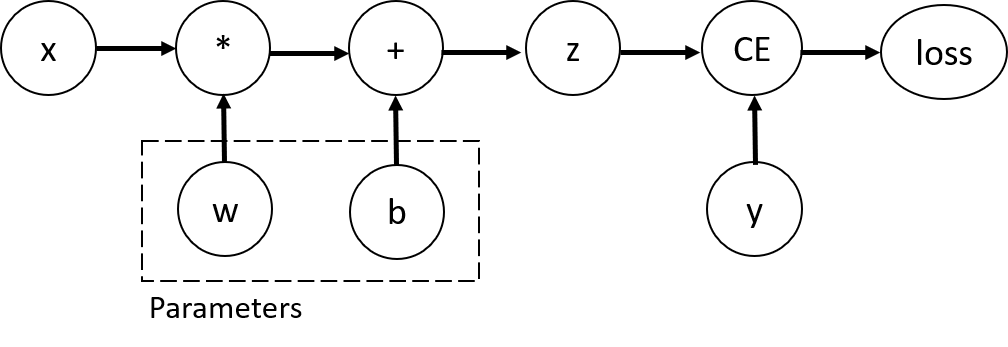

In [5]:
import torch

x = torch.ones(5) # input tensor
y = torch.zeros(3) # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad= True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z,y)
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")
loss.backward()
print(w.grad)
print(b.grad)

Gradient function for z = <AddBackward0 object at 0x7b660b084970>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7b660bb374c0>
tensor([[0.3133, 0.0439, 0.0355],
        [0.3133, 0.0439, 0.0355],
        [0.3133, 0.0439, 0.0355],
        [0.3133, 0.0439, 0.0355],
        [0.3133, 0.0439, 0.0355]])
tensor([0.3133, 0.0439, 0.0355])


Computing Gradients
To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameters, namely, we need
∂
l
o
s
s
∂
w
∂w
∂loss
​
  and
∂
l
o
s
s
∂
b
∂b
∂loss
​
  under some fixed values of x and y. To compute those derivatives, we call loss.backward(), and then retrieve the values from w.grad and b.grad:

## Note

* We can only obtain the grad properties for the leaf nodes of the computational
graph, which have requires_grad property set to True. For all other nodes in our graph, gradients will not be available.

* We can only perform gradient calculations using backward once on a given graph, for performance reasons. If we need to do several backward calls on the same graph, we need to pass retain_graph=True to the backward call.

# Disabling Gradient Tracking
By default, all tensors with requires_grad=True are tracking their computational history and support gradient computation. However, there are some cases when we do not need to do that, for example, when we have trained the model and just want to apply it to some input data, i.e. we only want to do forward computations through the network. We can stop tracking computations by surrounding our computation code with torch.no_grad() block:

In [3]:
z = torch.matmul(x,w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x,w)+b

print(z.requires_grad)

True
False


In [1]:
# Another way to achieve the same result is to use the detach() method on the tensor:

In [6]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


# There are reasons you might want to disable gradient tracking:
* To mark some parameters in your neural network as frozen parameters.

* To speed up computations when you are only doing forward pass, because computations on tensors that do not track gradients would be more efficient.

# Optimizing Model Parameters
Now that we have a model and data it’s time to train, validate and test our model by optimizing its parameters on our data. Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters (as we saw in the previous section), and optimizes these parameters using gradient descent. For a more detailed walkthrough of this process, check out this video on backpropagation from 3Blue1Brown.

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.6MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 269kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.47MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.1MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# Hyperparameters
Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates (read more about hyperparameter tuning)

We define the following hyperparameters for training:
Number of Epochs - the number times to iterate over the dataset

* Batch Size - the number of data samples propagated through the network before the parameters are updated

* Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [8]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

# Optimization Loop
Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each iteration of the optimization loop is called an epoch.

Each epoch consists of two main parts:
* The Train Loop - iterate over the training dataset and try to converge to optimal parameters.

* The Validation/Test Loop - iterate over the test dataset to check if model performance is improving.

Let’s briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to see the Full Implementation of the optimization loop.

# Loss Function
When presented with some training data, our untrained network is likely not to give the correct answer. Loss function measures the degree of dissimilarity of obtained result to the target value, and it is the loss function that we want to minimize during training. To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include nn.MSELoss (Mean Square Error) for regression tasks, and nn.NLLLoss (Negative Log Likelihood) for classification. nn.CrossEntropyLoss combines nn.LogSoftmax and nn.NLLLoss.

We pass our model’s output logits to nn.CrossEntropyLoss, which will normalize the logits and compute the prediction error.

In [10]:
Loss = nn.CrossEntropyLoss()

# Optimizer
Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent). All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

Inside the training loop, optimization happens in three steps:
* Call optimizer.zero_grad() to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

* Backpropagate the prediction loss with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.

* Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.

# Full Implementation
We define train_loop that loops over our optimization code, and test_loop that evaluates the model’s performance against our test data.

In [18]:
def train_loop(dataloader,model, loss_fn, optimizer):
  size = len(dataloader)
  # Set the model to training mode - important for batch normalization and dropout layers
  # Unnecessary in this situation but added for best practices
  model.train()

  for batch, (X,y) in enumerate(dataloader):
    pred = model(X)
    loss = loss_fn(pred, y)

    # backpropagation
    optimizer.zero_grad()   # to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
        loss, current = loss.item(), batch * batch_size + len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader,model, loss_fn ):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
      for batch, (X,y) in enumerate(dataloader):
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.183245  [   64/  938]
loss: 2.180631  [ 6464/  938]
loss: 2.132519  [12864/  938]
loss: 2.142528  [19264/  938]
loss: 2.094766  [25664/  938]
loss: 2.044245  [32064/  938]
loss: 2.064214  [38464/  938]
loss: 1.994965  [44864/  938]
loss: 1.994047  [51264/  938]
loss: 1.935557  [57664/  938]
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.933292 

Epoch 2
-------------------------------
loss: 1.954606  [   64/  938]
loss: 1.937553  [ 6464/  938]
loss: 1.829551  [12864/  938]
loss: 1.866993  [19264/  938]
loss: 1.772622  [25664/  938]
loss: 1.711021  [32064/  938]
loss: 1.732251  [38464/  938]
loss: 1.633102  [44864/  938]
loss: 1.655603  [51264/  938]
loss: 1.558139  [57664/  938]
Test Error: 
 Accuracy: 60.6%, Avg loss: 1.572818 

Epoch 3
-------------------------------
loss: 1.626439  [   64/  938]
loss: 1.599278  [ 6464/  938]
loss: 1.449960  [12864/  938]
loss: 1.522315  [19264/  938]
loss: 1.414826  [25664/  938]
loss: 1.393823  [32064/  9

# Save and Load the Model
In this section we will look at how to persist model state with saving, loading and running model predictions.

In [20]:
import torch
import torchvision.models as models


In [ ]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

To load model weights, you need to create an instance of the same model first, and then load the parameters using load_state_dict() method.

In the code below, we set weights_only=True to limit the functions executed during unpickling to only those necessary for loading weights. Using weights_only=True is considered a best practice when loading weights.

In [ ]:
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

# Saving and Loading Models with Shapes
When loading model weights, we needed to instantiate the model class first, because the class defines the structure of a network. We might want to save the structure of this class together with the model, in which case we can pass model (and not model.state_dict()) to the saving function:

In [ ]:
torch.save(model, 'model.pth')

We can then load the model as demonstrated below.

As described in Saving and loading torch.nn.Modules, saving state_dict is considered the best practice. However, below we use weights_only=False because this involves loading the model, which is a legacy use case for torch.save.

In [20]:
model = torch.load('model.pth', weights_only=False)